# PreProcess Data

In [144]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

hrLink = 'HayesRoth/hayes-roth.data'

hrDF = pd.read_csv(hrLink, header=None)
hrDF = hrDF.apply(LabelEncoder().fit_transform)
hrFeatures = hrDF.iloc[:, :-1].values.tolist()
hrLabels = hrDF.iloc[:, -1].tolist()


hrTestLink = 'HayesRoth/hayes-roth.test'

hrDFTest = pd.read_csv(hrLink, header=None)
hrDFTest = hrDFTest.apply(LabelEncoder().fit_transform)
hrTestFeatures = hrDFTest.iloc[:, :-1].values.tolist()
hrTestLabels = hrDF.iloc[:, -1].tolist()

In [40]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

carLink = 'CarEvaluation/car.data'

carDF = pd.read_csv(carLink, header=None)
carDF = carDF.apply(LabelEncoder().fit_transform)
carFeatures = carDF.iloc[:, :-1].values.tolist()
carLabels = carDF.iloc[:, -1].tolist()

In [41]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

cancerLink = 'BreastCancer/breast-cancer.data'

cancerDF = pd.read_csv(cancerLink, header=None)
cancerDF = cancerDF.apply(LabelEncoder().fit_transform)
cancerFeatures = cancerDF.iloc[:, :-1].values.tolist()
cancerLabels = cancerDF.iloc[:, -1].tolist()

# KNN without SKLearn

In [192]:
import random
from heapq import nsmallest
from collections import Counter
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

class KNNClassifier:
    
    def __init__(self, k=7, dis_metric='euclidean'):
        self.k = k
        self.dis_metric = dis_metric
        self.train_data = []
        self.train_labels = []
    

    def train(self, train_data, train_labels):
        self.train_data = train_data
        self.train_labels = train_labels
        
    def euclidean_distance(self, v1, v2):
        if len(v1) != len(v2):
            raise ValueError("Undefined for sequences of unequal length.")
        return sum((a - b) ** 2 for a, b in zip(v1, v2)) ** 0.5


    def get_neighbors(self, test_row):
        dis_metrics = {
            'euclidean': self.euclidean_distance,
        }
        if self.dis_metric not in dis_metrics:
            raise ValueError("Invalid distance metric")
        calc_distance = dis_metrics[self.dis_metric]
        distances = [
            (train_row, calc_distance(test_row, train_row), label)
            for train_row, label in zip(self.train_data, self.train_labels)
        ]
        k_nearest = nsmallest(self.k, distances, key=lambda x: x[1])
        return k_nearest


    def predict(self, x_test):
        predictions = []
        for test_case in x_test:
            neighbors = self.get_neighbors(test_case)
            output = [row[-1] for row in neighbors]
            prediction = Counter(output).most_common(1)[0][0]
            predictions.append(prediction)
        return predictions


# KFold cross validation

In [212]:
class kFoldCV:
    def __init__(self, classifier):
        self.classifier = classifier  
    
    def cross_val_split(self, dataset, num_folds):
        data_split = []
        data_copy = list(dataset)
        fold_size = len(dataset) // num_folds
        for _ in range(num_folds):
            if fold_size <= len(data_copy):
                fold = random.sample(data_copy, fold_size)
            else:
                fold = data_copy  # If the fold size is larger than the remaining data, use all the data
            data_split.append(fold)
            data_copy = [row for row in data_copy if row not in fold]
        return data_split

    def k_foldEvaluate(self, dataset, num_folds):
        folds = self.cross_val_split(dataset, num_folds)
        scores = []

        for fold_number, fold in enumerate(folds, 1):  # Start fold_number at 1
            train_set = [row for row in dataset if row not in fold]
            test_set = [row for row in fold]
            train_labels = [row[-1] for row in train_set]
            train_set = [row[:-1] for row in train_set]
            self.classifier.train(train_set, train_labels)
            actual = [row[-1] for row in test_set]
            test_set = [row[:-1] for row in test_set]
            predicted = self.classifier.predict(test_set)
            accuracy = self.calculate_accuracy(actual, predicted)
            scores.append(accuracy)

            print(f"Fold {fold_number}: Accuracy = {accuracy:.2f}%")

       
    def calculate_accuracy(self, actual, predicted):
        assert len(actual) == len(predicted)
        correct = sum(1 for a, p in zip(actual, predicted) if a == p)
        return (correct / len(actual)) * 100.0

In [193]:
def print_metrics(actual, predictions):
    if actual is None or predictions is None:
        print("Error: Both 'actual' and 'predictions' must be valid lists.")
        return
    
    assert len(actual) == len(predictions)
    correct = sum(1 for a, p in zip(actual, predictions) if a == p)
    accuracy = (correct / len(actual)) * 100.0
    print("Accuracy of kNN model: {:.2f}%".format(accuracy))
    return accuracy

# Packages used for this KNN

In [227]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler


import numpy as np
from scipy import stats

# Hayes Roth Dataset Accuracy

In [231]:
X_train, X_test, y_train, y_test = train_test_split(hrFeatures, hrLabels, test_size=0.2)
knn = KNNClassifier()
knn.train(X_train, y_train)
hr_euc_pred = knn.predict(X_test)
nosklearnAccuracyHR = print_metrics(y_test, hr_euc_pred)
kfcv = kFoldCV(knn)
kfcv.k_foldEvaluate(hrTestFeatures, 10)

# SKlearn
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
k = 3  # Number of neighbors
knn_classifier = KNeighborsClassifier(n_neighbors=k)
knn_classifier.fit(X_train, y_train)
y_pred = knn_classifier.predict(X_test)
sk_accuracy_HR = accuracy_score(y_test, y_pred)
print(f"Accuracy of kNN model using SKlearn: {sk_accuracy_HR * 100:.2f}%")

X = np.concatenate((X_train, X_test))
y = np.concatenate((y_train, y_test))

# Perform k-fold cross-validation
num_folds = 10  # Number of folds
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

scores = []

for train_index, test_index in kf.split(X):
    X_train_fold, X_test_fold = X[train_index], X[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]

    # Scale the data
    X_train_fold = scaler.fit_transform(X_train_fold)
    X_test_fold = scaler.transform(X_test_fold)

    # Fit the classifier and make predictions
    knn_classifier.fit(X_train_fold, y_train_fold)
    y_pred_fold = knn_classifier.predict(X_test_fold)

    # Calculate accuracy for this fold
    accuracy = accuracy_score(y_test_fold, y_pred_fold)
    scores.append(accuracy)

# Print accuracy for each fold
for i, accuracy in enumerate(scores, 1):
    print(f"Fold {i} Accuracy: {accuracy * 100:.2f}%")


Accuracy of kNN model: 59.26%
Fold 1: Accuracy = 38.46%
Fold 2: Accuracy = 38.46%
Fold 3: Accuracy = 53.85%
Fold 4: Accuracy = 38.46%
Fold 5: Accuracy = 23.08%
Fold 6: Accuracy = 38.46%
Fold 7: Accuracy = 30.77%
Fold 8: Accuracy = 30.77%
Fold 9: Accuracy = 38.46%
Fold 10: Accuracy = 46.15%
Accuracy of kNN model using SKlearn: 44.44%
Fold 1 Accuracy: 64.29%
Fold 2 Accuracy: 42.86%
Fold 3 Accuracy: 38.46%
Fold 4 Accuracy: 53.85%
Fold 5 Accuracy: 61.54%
Fold 6 Accuracy: 46.15%
Fold 7 Accuracy: 61.54%
Fold 8 Accuracy: 38.46%
Fold 9 Accuracy: 38.46%
Fold 10 Accuracy: 53.85%


# Car Evaluation Dataset Accuracy

In [233]:
X_train, X_test, y_train, y_test = train_test_split(carFeatures, carLabels, test_size=0.2)
knn = KNNClassifier()
knn.train(X_train, y_train)
car_euc_pred = knn.predict(X_test)
nosklearnAccuracyCar = print_metrics(y_test, car_euc_pred)
kfcv = kFoldCV(knn)
kfcv.k_foldEvaluate(carFeatures, 10)

# SKlearn
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
k = 3  # Number of neighbors
knn_classifier = KNeighborsClassifier(n_neighbors=k)
knn_classifier.fit(X_train, y_train)
y_pred = knn_classifier.predict(X_test)
sk_accuracy_Car = accuracy_score(y_test, y_pred)
print(f"Accuracy of kNN model using SKlearn: {sk_accuracy_Car * 100:.2f}%")


X = np.concatenate((X_train, X_test))
y = np.concatenate((y_train, y_test))

# Perform k-fold cross-validation
num_folds = 10  # Number of folds
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

scores = []

for train_index, test_index in kf.split(X):
    X_train_fold, X_test_fold = X[train_index], X[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]

    # Scale the data
    X_train_fold = scaler.fit_transform(X_train_fold)
    X_test_fold = scaler.transform(X_test_fold)

    # Fit the classifier and make predictions
    knn_classifier.fit(X_train_fold, y_train_fold)
    y_pred_fold = knn_classifier.predict(X_test_fold)

    # Calculate accuracy for this fold
    accuracy = accuracy_score(y_test_fold, y_pred_fold)
    scores.append(accuracy)

# Print accuracy for each fold
for i, accuracy in enumerate(scores, 1):
    print(f"Fold {i} Accuracy: {accuracy * 100:.2f}%")


Accuracy of kNN model: 91.91%
Fold 1: Accuracy = 0.58%
Fold 2: Accuracy = 0.58%
Fold 3: Accuracy = 2.91%
Fold 4: Accuracy = 1.74%
Fold 5: Accuracy = 1.16%
Fold 6: Accuracy = 2.33%
Fold 7: Accuracy = 4.65%
Fold 8: Accuracy = 2.33%
Fold 9: Accuracy = 1.74%
Fold 10: Accuracy = 5.81%
Accuracy of kNN model using SKlearn: 91.62%
Fold 1 Accuracy: 93.06%
Fold 2 Accuracy: 83.82%
Fold 3 Accuracy: 94.80%
Fold 4 Accuracy: 84.97%
Fold 5 Accuracy: 90.17%
Fold 6 Accuracy: 91.33%
Fold 7 Accuracy: 95.38%
Fold 8 Accuracy: 84.97%
Fold 9 Accuracy: 84.88%
Fold 10 Accuracy: 92.44%


# Breast Cancer Dataset Accuracy

In [234]:
X_train, X_test, y_train, y_test = train_test_split(cancerFeatures, cancerLabels, test_size=0.2)
knn = KNNClassifier()
knn.train(X_train, y_train)
cancer_euc_pred = knn.predict(X_test)
nosklearnAccuracyCancer = print_metrics(y_test, cancer_euc_pred)
kfcv = kFoldCV(knn)
kfcv.k_foldEvaluate(cancerFeatures, 10)

# SKlearn
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
k = 3  # Number of neighbors
knn_classifier = KNeighborsClassifier(n_neighbors=k)
knn_classifier.fit(X_train, y_train)
y_pred = knn_classifier.predict(X_test)
sk_accuracy_Cancer = accuracy_score(y_test, y_pred)
print(f"Accuracy of kNN model using SKlearn: {sk_accuracy_Cancer * 100:.2f}%")


X = np.concatenate((X_train, X_test))
y = np.concatenate((y_train, y_test))

# Perform k-fold cross-validation
num_folds = 10  # Number of folds
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

scores = []

for train_index, test_index in kf.split(X):
    X_train_fold, X_test_fold = X[train_index], X[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]

    # Scale the data
    X_train_fold = scaler.fit_transform(X_train_fold)
    X_test_fold = scaler.transform(X_test_fold)

    # Fit the classifier and make predictions
    knn_classifier.fit(X_train_fold, y_train_fold)
    y_pred_fold = knn_classifier.predict(X_test_fold)

    # Calculate accuracy for this fold
    accuracy = accuracy_score(y_test_fold, y_pred_fold)
    scores.append(accuracy)

# Print accuracy for each fold
for i, accuracy in enumerate(scores, 1):
    print(f"Fold {i} Accuracy: {accuracy * 100:.2f}%")


Accuracy of kNN model: 72.41%
Fold 1: Accuracy = 28.57%
Fold 2: Accuracy = 17.86%
Fold 3: Accuracy = 32.14%
Fold 4: Accuracy = 39.29%
Fold 5: Accuracy = 46.43%
Fold 6: Accuracy = 39.29%
Fold 7: Accuracy = 25.00%
Fold 8: Accuracy = 10.71%
Fold 9: Accuracy = 32.14%
Fold 10: Accuracy = 26.32%
Accuracy of kNN model using SKlearn: 70.69%
Fold 1 Accuracy: 79.31%
Fold 2 Accuracy: 79.31%
Fold 3 Accuracy: 75.86%
Fold 4 Accuracy: 82.76%
Fold 5 Accuracy: 58.62%
Fold 6 Accuracy: 75.86%
Fold 7 Accuracy: 64.29%
Fold 8 Accuracy: 75.00%
Fold 9 Accuracy: 82.14%
Fold 10 Accuracy: 78.57%


# t-test

In [235]:
import numpy as np
from scipy import stats


# Sample data for two groups
normalKNN = [nosklearnAccuracyHR, nosklearnAccuracyCar, nosklearnAccuracyCancer]
sklearnKNN = [sk_accuracy_HR*100, sk_accuracy_Car*100, sk_accuracy_Cancer*100]


# Perform the independent samples t-test
t_stat, p_value = stats.ttest_ind(normalKNN, sklearnKNN)

# Check the p-value to determine significance
if p_value < 0.05:  # 0.05 is a common significance level
    print("A notable significant difference exists between the two groups.")
else:
    print("No significant difference between the groups.")


No significant difference between the groups.


# Graphical Representation

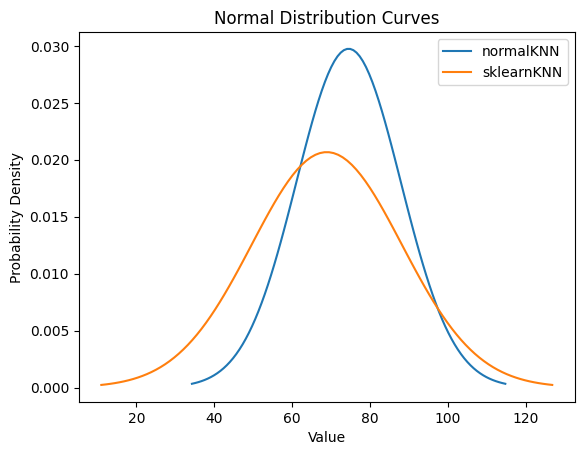

In [236]:
mu1, std1 = np.mean(normalKNN), np.std(normalKNN)
x1 = np.linspace(mu1 - 3*std1, mu1 + 3*std1, 100)
pdf1 = stats.norm.pdf(x1, mu1, std1)

# Create a normal distribution curve for group2
mu2, std2 = np.mean(sklearnKNN), np.std(sklearnKNN)
x2 = np.linspace(mu2 - 3*std2, mu2 + 3*std2, 100)
pdf2 = stats.norm.pdf(x2, mu2, std2)

# Plot the curves
plt.plot(x1, pdf1, label='normalKNN')
plt.plot(x2, pdf2, label='sklearnKNN')
plt.legend()

plt.title('Normal Distribution Curves')
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.show()